In [1]:
import re
import base64
import os
from langchain_text_splitters import MarkdownHeaderTextSplitter
from openai import OpenAI

with open("./a-survey-to-transformers.md", "r") as file:
    md = file.read()

In [2]:
image_pattern = r"!\[Image\]\((data:image/[a-zA-Z]+;base64,[^)]*?)\)"
image_matches = re.findall(image_pattern, md)

image_folder = "./images/a-survey-to-transformers"

os.makedirs(image_folder, exist_ok=True)

In [3]:
if image_matches:
    for idx, image in enumerate(image_matches, start=1):
        file_name = f"{image_folder}/image_{idx}.png"
        with open(file_name, "wb") as img_file:
            base64_code = base64.b64decode(image.split(",")[1])
            img_file.write(base64_code)
            md = md.replace(image, f"{file_name}")

    with open(f"./updated_markdown.md", "w") as updated_md_file:
        updated_md_file.write(md)

In [ ]:
headers_to_split_on = [
    ("#", "h1"),
    ("##", "h2"),
    ("###", "h3"),
    ("####", "h4"),
]

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on,
    strip_headers=False
)

In [5]:
with open("./updated_markdown.md", "r") as file:
    updated_markdown_file = file.read()

md_header_splits = markdown_splitter.split_text(updated_markdown_file)

In [6]:
os.path.isfile('./images/a-survey-to-transformers/image_1.png')

True

In [ ]:
from uuid import uuid4
from PIL import Image
from schemas import ImageMetadata, TextMetadata
from utils import generate_image_metadata, generate_text_metadata
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size = 1024
chunk_overlap = 200

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", " ", ""]
)

client = OpenAI(
    api_key="sk-1234",
    base_url="http://localhost:9090/v1"
)

final_splits = []
img_pattern = r"!\[[^\]]*\]\(([^)]+\.(?:png|jpg|jpeg|gif))\)"
for chunk in md_header_splits:
    splits = text_splitter.split_text(chunk.page_content)
    for split in splits:
        matches = re.findall(img_pattern, split)
        split_no_images = re.sub(img_pattern, "", split)
        text_metadata: TextMetadata = generate_text_metadata(chunk_text=split_no_images, section_context=chunk)
        hypothetical_questions = "\n- ".join(text_metadata.hypothetical_questions)
        chunk_with_metadata = {
            "metadata": {
                "chunk_id": str(uuid4()),
                "section_hierarchy": {**chunk.metadata},
                "keywords": text_metadata.keywords,
                "entities": text_metadata.entities,
                "key_objects": text_metadata.key_objects,
                "tags": text_metadata.tags,
                "summary": text_metadata.summary,
                "mentioned_images": matches,
                "hypothetical_questions": hypothetical_questions,
                "doc_type": "text",
            },
            "page_content": f"""
            Keywords: {', '.join(text_metadata.keywords)}
            Key Objects: {', '.join(text_metadata.key_objects)}
            Refers to Images: {', '.join(matches) if matches else 'None'}

            Hypothetical Questions:
            - {hypothetical_questions}

            ---
            Summary:
            {text_metadata.summary}
            
            Original Text:
            {split_no_images}

            Contextualized Text:
            {text_metadata.contextual_text}
            """
        }
        final_splits.append(chunk_with_metadata)
        for match in matches:
            image = Image.open(match)
            image_base64 = base64.b64encode(image.tobytes()).decode('utf-8')
            response = client.chat.completions.create(
                model="ollama/gemma3:12b",
                messages=[
                    {"role": "system", "content": "You are a vision expert that helps describe images."},
                    {"role": "user", "content": f"Describe the following image in details:\n\n"},
                    {"role": "user", "content": f"---Start of Image---\n{image_base64}\n---End of Image---"},
                ]
            )
            description = response.choices[0].message.content
            image_chunk = {
                "metadata": {
                    "doc_id": str(uuid4()),
                    "source": match,
                    "description": description,
                    "parent_doc_id": chunk_with_metadata["metadata"]["doc_id"],
                    "doc_type": "image",
                },
                "page_content": description
            }
            final_splits.append(image_chunk)

print(f"Total chunks created: {len(final_splits)}")

ResponseError: model "ollama/gemma3:12b" not found, try pulling it first (status code: 404)

In [17]:
final_splits[0]

{'metadata': {'doc_id': '2d7c6c99-f7b2-4dd3-8b90-1ffd8fa910d2',
  'Header 2': 'A Survey of Transformers',
  'images': [],
  'type': 'text'},
 'page_content': '## A Survey of Transformers  \nTIANYANG LIN, YUXIN WANG, XIANGYANG LIU, and XIPENG QIU $^{∗}$, School of Computer Science, Fudan University, China and Shanghai Key Laboratory of Intelligent Information Processing, Fudan University, China'}

In [16]:
for idx, chunk in enumerate(final_splits):
    if "doc_type" in chunk["metadata"].keys():
        print(f"{idx}. {chunk}")

13. {'metadata': {'doc_id': '10d48bce-a5f7-4a9b-9e8f-66a44d0d8266', 'doc_type': 'image', 'source': './images/a-survey-to-transformers/image_1.png', 'description': 'Okay, I\'m analyzing the text you provided. This appears to be a large block of encoded or compressed image data, likely representing a bitmap or similar raster graphic. Here\'s a breakdown of what I\'m seeing and what it likely signifies.\n\n**1. Encoding Style:**\n\n*   **Base64-like, but not standard:** The text\'s structure has similarities to Base64, which is common for encoding binary data into text format. However, it\'s not exactly a valid Base64 string.\n*   **Huffman-style Encoding/Run-Length Encoding (Possible):** I am seeing repeating patterns (e.g., \'k5OTtLS0\', \'29vbenp69\') that strongly indicate a form of run-length encoding (RLE) or a custom, lightweight compression.  These are likely representing extended codes for pixels or small sequences of pixels.  It\'s possible the data has been further processed af

In [ ]:
random_chunk = final_splits[36]
random_chunk

{'metadata': {'Header 2': '4.1 Sparse Attention',
  'images': ['./images/a-survey-to-transformers/image_6.png',
   './images/a-survey-to-transformers/image_7.png']},
 'page_content': '  \nFig. 6. Other types of sparse attentions. The red box indicates the query position, and the orange nodes/squares means corresponding tokens are attended to by the query.  \n  \n4.1.2 Content-based Sparse Attention . Another line of work creates a sparse graph based on input content, i.e., the sparse connections are conditioned on inputs.'}

{'role': 'user',
 'content': [{'type': 'text',
   'text': 'Could you summarize the text and the images?'},
  {'type': 'image_url',
   'image_url': {'url': ''}},
  {'type': 'image_url',
   'image_url': {'url': ''}},
  {'type': 'text',
   'text': '  \nFig. 6. Other types of sparse attentions. The red box indicates the query position, and the orange nodes/squares means corresponding tokens are attended to by the query.  \n  \n4.1.2 Content-based Sparse Attention . Another line of work creates a sparse graph based on input content, i.e., the sparse connections are conditioned on inputs.'}]}
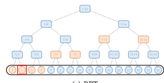
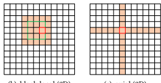

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key="sk-1234",
    base_url="http://localhost:9090/v1",
)

with open("./images/a-survey-to-transformers/image_1.png", "rb") as img_file:
    image_data = img_file.read()
image_base64 = base64.b64encode(image_data).decode('utf-8')

system_prompt = {"role": "system", "content": "You are a vision expert that can see images."}
messages = list()
messages.append(system_prompt)

user_message = {
    "role": "user",
    "content": [
        {"type": "text", "text": "Could you summarize the text and the images?"},
    ]
}

for image in random_chunk["metadata"]["images"]:
    encoded_base64 = base64.b64encode(open(image, "rb").read()).decode('utf-8') 
    user_message["content"].append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encoded_base64}"
            },
        },   
    )
messages.append(user_message)

user_message["content"].append(
    {
        "type": "text",
        "text": random_chunk["page_content"]
    }
)


user_message

In [ ]:
response = client.chat.completions.create(
    model="ollama/gemma3:12b",
    messages=messages
)

In [ ]:
print(response.choices[0].message.content)

Here's a summary of the text and images:

**Overall:** The images and text describe a type of attention mechanism called "sparse attention." This mechanism is designed to make computations more efficient by only attending to a select few tokens (rather than all of them) during processing.

**Key Points:**

*   **Sparse Attention:** This is an attention mechanism that restricts which tokens are attended to, making it more efficient.
*   **Content-Based:** The connections (which tokens are attended to) are determined by the input data itself.
*   **Visual Representation:** The images use visual cues to show this:
    *   **Red Box:** Highlights the query position (where the attention is originating).
    *   **Orange Nodes/Squares:** Indicate the tokens that the query is paying attention to.

Essentially, the system creates a sparse graph based on the content of the input to define which tokens the query should focus on.
